# [1].LOADING LIBRARIES

In [1]:

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score,train_test_split
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,SnowballStemmer
from bs4 import BeautifulSoup
from tqdm import tqdm
import re
import os
import sqlite3
import time
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.neighbors import KNeighborsClassifier
import datetime
from sklearn.metrics import confusion_matrix,f1_score,precision_recall_curve,precision_score,recall_score,roc_auc_score,roc_curve,accuracy_score,classification_report

import scikitplot.metrics as skplt

## LOADING DATA & EDA

In [2]:
# loading the data
con = sqlite3.connect('database.sqlite')

Amazon_Food_Reviews = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = Amazon_Food_Reviews['Score']
positiveNegative = actualScore.map(partition) 
Amazon_Food_Reviews['Score'] = positiveNegative
print("Number of data points in our data", Amazon_Food_Reviews.shape)
Amazon_Food_Reviews.head(3)


Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
Amazon_Food_Reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
Amazon_Food_Reviews_Sorted_Data= Amazon_Food_Reviews.sort_values('ProductId',axis=0, inplace=False, kind='quicksort', na_position='last')
Amazon_Food_Reviews_Duplicates_Dropped= Amazon_Food_Reviews_Sorted_Data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)
print("{:07.3f} % of data removed during duplicates removal operation".format((1-(Amazon_Food_Reviews_Duplicates_Dropped.shape[0])/(Amazon_Food_Reviews_Sorted_Data.shape[0]))*100))

000.280 % of data removed during duplicates removal operation


In [5]:
Amazon_Food_Reviews_Preprocessed=Amazon_Food_Reviews_Duplicates_Dropped[Amazon_Food_Reviews_Duplicates_Dropped.HelpfulnessNumerator<=Amazon_Food_Reviews_Duplicates_Dropped.HelpfulnessDenominator]
print("{:07.3f} % of data removed".format(np.round((1-(Amazon_Food_Reviews_Preprocessed.shape[0])/(Amazon_Food_Reviews_Duplicates_Dropped.shape[0]))*100)))

000.000 % of data removed


# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [6]:
def DeContraction(document):
    document= re.sub(r"won\'t","will not",document)
    document= re.sub(r"can\'t","can not",document)
    document= re.sub(r"\'t","not",document)
    document= re.sub(r"\'m","am",document)
    document= re.sub(r"\'re","are",document)
    document= re.sub(r"\'ve","have",document)
    document= re.sub(r"\'d","would",document)
    document= re.sub(r"\'s","is",document)
    document= re.sub(r"\'ll","will",document)
    return document

In [7]:
Custom_StopWords = [word for word in stopwords.words('english') if word not in ['no','nor','not']]

In [8]:
from tqdm import tqdm
def Preprocessing(Text_Data):
    Preprocessed_Text =[]
    for document in tqdm(Text_Data):
        document= re.sub(r"http\S+","",document)
        document = BeautifulSoup(document,'html').get_text()
        document=DeContraction(document)
        document = re.sub(r"\S*\d\S*","",document).strip()
        document = re.sub("[^a-zA-Z]+",' ',document)
        document = ' '.join(word.lower() for word in document.split() if word.lower() not in Custom_StopWords)
        Preprocessed_Text.append(document)
    return Preprocessed_Text

In [9]:
Preprocessed_Amazon_Reviews = Preprocessing(Amazon_Food_Reviews_Preprocessed['Text'].values)
np.random.seed(42)
print("{} :{}".format(np.random.randint(Amazon_Food_Reviews_Preprocessed.shape[0]),
                      Preprocessed_Amazon_Reviews[np.random.randint(Amazon_Food_Reviews_Preprocessed.shape[0])]))

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:12<00:00, 397.08it/s]

860 :ihave tried mixes pancakes theyhave awful one really good buy stock co people buying product iam sure


# [4] FEATURIZATION OF ENTIRE DATASET

## [4.1] BAG OF WORDS

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
cnt_vectorizer= CountVectorizer()
Count_Vectorized_Reviews=cnt_vectorizer.fit_transform(Preprocessed_Amazon_Reviews)
print("Type of Output:{},Size:{}".format(type(Count_Vectorized_Reviews),Count_Vectorized_Reviews.get_shape()))

Type of Output:<class 'scipy.sparse.csr.csr_matrix'>,Size:(4986, 13278)


## [4.2] Bi-Grams and n-Grams.

In [11]:
#Count Vector With Bi-Grams,Words considering whose frequency greater than 10
Cnt_Vectorizer_Bigrams=CountVectorizer(ngram_range=(1,2),min_df=10)
Count_Vectorized_Reviews_Bigram = Cnt_Vectorizer_Bigrams.fit_transform(Preprocessed_Amazon_Reviews)
print("Type of Output:{},Size:{}".format(type(Count_Vectorized_Reviews_Bigram),Count_Vectorized_Reviews_Bigram.get_shape()))

Type of Output:<class 'scipy.sparse.csr.csr_matrix'>,Size:(4986, 3156)


## [4.3] TF-IDF

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer_bigram = TfidfVectorizer(ngram_range=(1,2),min_df=10)
TFIDF_Vectorized_Reviews_Bigram=tfidf_vectorizer_bigram.fit_transform(Preprocessed_Amazon_Reviews)
print("Type of Output:{},Size:{}".format(type(TFIDF_Vectorized_Reviews_Bigram),TFIDF_Vectorized_Reviews_Bigram.get_shape()))

Type of Output:<class 'scipy.sparse.csr.csr_matrix'>,Size:(4986, 3156)


## [4.4] Word2Vec

In [13]:
List_Of_document=[]
for document in Preprocessed_Amazon_Reviews:
    List_Of_document.append(document.split())

In [14]:
from gensim.models import Word2Vec
def Train_Word2Vec(List_Of_document,want_to_train_own_word2vec_model=True):
    if want_to_train_own_word2vec_model:
        return Word2Vec(List_Of_document,min_count=5,size=128,workers=os.cpu_count()-2)

In [15]:
Word2Vec_Model = Train_Word2Vec(List_Of_document)
w2v_words=list(Word2Vec_Model.wv.vocab)

### [4.4.1] AVG WORD2VEC

In [16]:
def Weighted_Word2Vec(Word2Vec_Model,List_Of_document):
    Documents_Vector=[]
    for document in tqdm(List_Of_document):
        Document_Vector=np.zeros(128)
        count_words=0
        for word in document:
            if word in w2v_words:
                word_vector=Word2Vec_Model.wv[word]
                Document_Vector+=word_vector
                count_words+=1
        if count_words!=0:
            Document_Vector/=count_words
        Documents_Vector.append(Document_Vector)
    return Documents_Vector

In [17]:
Weighted_Word2Vec_Vectorization=Weighted_Word2Vec(Word2Vec_Model,List_Of_document)

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:07<00:00, 695.68it/s]


### [4.4.2] TFIDF WORD2VEC

In [18]:
tfidf_model =TfidfVectorizer()
tfidf_model.fit(Preprocessed_Amazon_Reviews)
IDF_Dictionary= dict(zip(tfidf_model.get_feature_names(),tfidf_model.idf_))

In [19]:
def TFIDF_WORD2VEC(tfidf_model,IDF_Dictionary,List_Of_document):
    TFIDF_FEATURES = tfidf_model.get_feature_names()
    TFIDF_Documents_Vector=[]
    row=0
    for Document in tqdm(List_Of_document):
        Document_Vector=np.zeros(128)
        weighted_sum=0
        for word in Document:
            if word in w2v_words and word in TFIDF_FEATURES:
                word_vector=Word2Vec_Model.wv[word]
                word_tfidf= IDF_Dictionary[word]*(Document.count(word)/len(Document))
                Document_Vector+=word_vector*word_tfidf
                weighted_sum+=word_tfidf
        if weighted_sum!=0:
            Document_Vector/=weighted_sum
        TFIDF_Documents_Vector.append(Document_Vector)
        row+=1
    return TFIDF_Documents_Vector

In [20]:
TFIDF_Word2Vec_Vectorization=TFIDF_WORD2VEC(tfidf_model,IDF_Dictionary,List_Of_document)

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:46<00:00, 106.34it/s]


# [ 5] VISUALIZATION

In [22]:
import time
os.mkdir('Visualization/')
def Visualization(Dataset,Score,Title,no_of_dims=2,perplexity=50,learning_rate=200):
    plt.figure(figsize=(12,10))
    TSNE_Model = TSNE(n_components=no_of_dims,perplexity=perplexity,learning_rate=learning_rate,n_jobs=-1,n_iter=5000)
    start_time=time.time()
    X_TSNE=TSNE_Model.fit_transform(Dataset)
    stop_time=time.time()
    Data = np.hstack((X_TSNE,Score.reshape(-1,1)))
    TSNE_DF=pd.DataFrame(Data,columns=['Dimension_x','Dimension_y','Score'])
    colors = {0:'red', 1:'blue'}
    plt.scatter(TSNE_DF['Dimension_x'], TSNE_DF['Dimension_y'], c=TSNE_DF['Score'].apply(lambda x: colors[x]))
    plt.title(Title)
    green_patch = mpatches.Patch(color='green', label='perplexity :'+str(perplexity))
    black_patch = mpatches.Patch(color='black', label='learning rate :'+str(learning_rate))
    plt.xlabel('Dimension_x')
    plt.ylabel('Dimension_y')
    plt.legend(handles=[green_patch, black_patch])
    Image = os.path.join('Visualization/',Title+'n_components'+'_'+str(no_of_dims)+'_'+'perplexity'+'_'+str(perplexity)+'_'+'learning_rate'+'_'+str(learning_rate)+'.png')
    plt.savefig(fname =Image,dpi=500,format='png')
    Total_Time=(stop_time-start_time)/60
    print('Execution Time:{}'.format(Total_Time))

## [5.1] COUNT VECTORIZATION

Execution Time:9.093512686093648


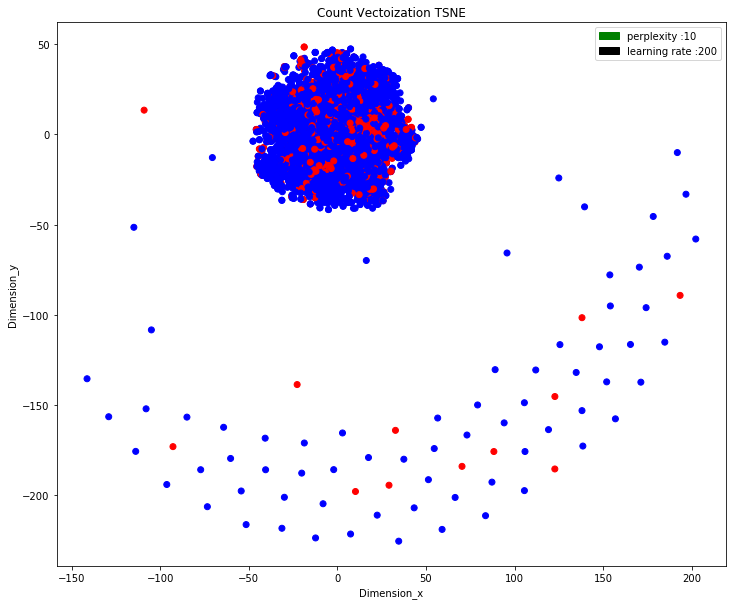

In [23]:
Visualization(Dataset=Count_Vectorized_Reviews.toarray(),Score=Amazon_Food_Reviews_Preprocessed['Score'].values,Title='Count Vectoization TSNE',no_of_dims=2,perplexity=10,learning_rate=200)

Execution Time:7.80785372654597


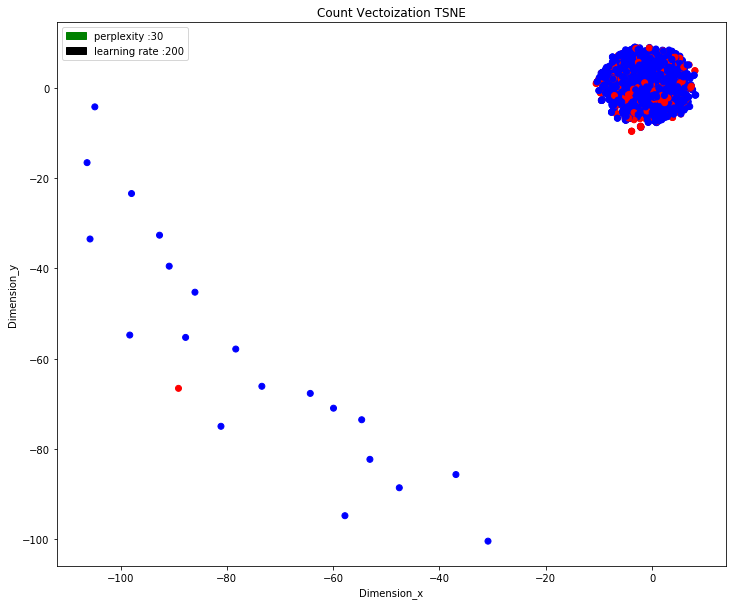

In [24]:
Visualization(Dataset=Count_Vectorized_Reviews.toarray(),Score=Amazon_Food_Reviews_Preprocessed['Score'].values,Title='Count Vectoization TSNE',no_of_dims=2,perplexity=30,learning_rate=200)

In [ ]:
Visualization(Dataset=Count_Vectorized_Reviews.toarray(),Score=Amazon_Food_Reviews_Preprocessed['Score'].values,Title='Count Vectoization TSNE',no_of_dims=2,perplexity=20,learning_rate=200)

In [ ]:
Visualization(Dataset=Count_Vectorized_Reviews.toarray(),Score=Amazon_Food_Reviews_Preprocessed['Score'].values,Title='Count Vectoization TSNE',no_of_dims=2,perplexity=40,learning_rate=200)

In [ ]:
Visualization(Dataset=Count_Vectorized_Reviews.toarray(),Score=Amazon_Food_Reviews_Preprocessed['Score'].values,Title='Count Vectoization TSNE')

In [ ]:
Visualization(Dataset=Count_Vectorized_Reviews.toarray(),Score=Amazon_Food_Reviews_Preprocessed['Score'].values,Title='Count Vectoization TSNE',no_of_dims=2,perplexity=100,learning_rate=200)

## [5.2] BIGRAM COUNT VECTORIZATION 

In [ ]:
Visualization(Dataset=Count_Vectorized_Reviews_Bigram.toarray(),Score=Amazon_Food_Reviews_Preprocessed['Score'].values,Title='BiGRAM Count Vectoization TSNE',no_of_dims=2,perplexity=10,learning_rate=200)

In [ ]:
Visualization(Dataset=Count_Vectorized_Reviews_Bigram.toarray(),Score=Amazon_Food_Reviews_Preprocessed['Score'].values,Title='BiGRAM Count Vectoization TSNE',no_of_dims=2,perplexity=20,learning_rate=200)

In [ ]:
Visualization(Dataset=Count_Vectorized_Reviews_Bigram.toarray(),Score=Amazon_Food_Reviews_Preprocessed['Score'].values,Title='BiGRAM Count Vectoization TSNE',no_of_dims=2,perplexity=30,learning_rate=200)

In [ ]:
Visualization(Dataset=Count_Vectorized_Reviews_Bigram.toarray(),Score=Amazon_Food_Reviews_Preprocessed['Score'].values,Title='BiGRAM Count Vectoization TSNE',no_of_dims=2,perplexity=40,learning_rate=200)

In [ ]:
Visualization(Dataset=Count_Vectorized_Reviews_Bigram.toarray(),Score=Amazon_Food_Reviews_Preprocessed['Score'].values,Title='BiGRAM Count Vectoization TSNE')

In [ ]:
Visualization(Dataset=Count_Vectorized_Reviews_Bigram.toarray(),Score=Amazon_Food_Reviews_Preprocessed['Score'].values,Title='BiGRAM Count Vectoization TSNE',no_of_dims=2,perplexity=100,learning_rate=200)

## [5.3] TFIDF BIGRAM VECTORIZATION 

In [ ]:
Visualization(Dataset=TFIDF_Vectorized_Reviews_Bigram.toarray(),Score=Amazon_Food_Reviews_Preprocessed['Score'].values,Title='BiGRAM TFIDF Vectoization TSNE',no_of_dims=2,perplexity=10,learning_rate=200)

In [ ]:
Visualization(Dataset=TFIDF_Vectorized_Reviews_Bigram.toarray(),Score=Amazon_Food_Reviews_Preprocessed['Score'].values,Title='BiGRAM TFIDF Vectoization TSNE',no_of_dims=2,perplexity=30,learning_rate=200)

In [ ]:
Visualization(Dataset=TFIDF_Vectorized_Reviews_Bigram.toarray(),Score=Amazon_Food_Reviews_Preprocessed['Score'].values,Title='BiGRAM TFIDF Vectoization TSNE',no_of_dims=2,perplexity=40,learning_rate=200)

In [ ]:
Visualization(Dataset=TFIDF_Vectorized_Reviews_Bigram.toarray(),Score=Amazon_Food_Reviews_Preprocessed['Score'].values,Title='BiGRAM TFIDF Vectoization TSNE')

In [ ]:
Visualization(Dataset=TFIDF_Vectorized_Reviews_Bigram.toarray(),Score=Amazon_Food_Reviews_Preprocessed['Score'].values,Title='BiGRAM TFIDF Vectoization TSNE',no_of_dims=2,perplexity=100,learning_rate=200)

## [5.4.1] AVG WEIGHTED WORD2VEC VECTORIZATION 

In [ ]:
Visualization(Dataset=Weighted_Word2Vec_Vectorization,Score=Amazon_Food_Reviews_Preprocessed['Score'].values,Title='AVG WORD2VEC Vectoization TSNE',no_of_dims=2,perplexity=10,learning_rate=200)

In [ ]:
Visualization(Dataset=Weighted_Word2Vec_Vectorization,Score=Amazon_Food_Reviews_Preprocessed['Score'].values,Title='AVG WORD2VEC Vectoization TSNE',no_of_dims=2,perplexity=20,learning_rate=200)

In [ ]:
Visualization(Dataset=Weighted_Word2Vec_Vectorization,Score=Amazon_Food_Reviews_Preprocessed['Score'].values,Title='AVG WORD2VEC Vectoization TSNE',no_of_dims=2,perplexity=30,learning_rate=200)

In [ ]:
Visualization(Dataset=Weighted_Word2Vec_Vectorization,Score=Amazon_Food_Reviews_Preprocessed['Score'].values,Title='AVG WORD2VEC Vectoization TSNE',no_of_dims=2,perplexity=40,learning_rate=200)

In [ ]:
Visualization(Dataset=Weighted_Word2Vec_Vectorization,Score=Amazon_Food_Reviews_Preprocessed['Score'].values,Title='AVG WORD2VEC Vectoization TSNE')

In [ ]:
Visualization(Dataset=Weighted_Word2Vec_Vectorization,Score=Amazon_Food_Reviews_Preprocessed['Score'].values,Title='AVG WORD2VEC Vectoization TSNE',no_of_dims=2,perplexity=100,learning_rate=200)

## [5.4.2] TFIDF WEIGHTED WORD2VEC VECTORIZATION 

In [ ]:
Visualization(Dataset=TFIDF_Word2Vec_Vectorization,Score=Amazon_Food_Reviews_Preprocessed['Score'].values,Title='TFIDF WORD2VEC Vectoization TSNE',no_of_dims=2,perplexity=10,learning_rate=200)

In [ ]:
Visualization(Dataset=TFIDF_Word2Vec_Vectorization,Score=Amazon_Food_Reviews_Preprocessed['Score'].values,Title='TFIDF WORD2VEC Vectoization TSNE',no_of_dims=2,perplexity=20,learning_rate=200)

In [ ]:
Visualization(Dataset=TFIDF_Word2Vec_Vectorization,Score=Amazon_Food_Reviews_Preprocessed['Score'].values,Title='TFIDF WORD2VEC Vectoization TSNE',no_of_dims=2,perplexity=30,learning_rate=200)

In [ ]:
Visualization(Dataset=TFIDF_Word2Vec_Vectorization,Score=Amazon_Food_Reviews_Preprocessed['Score'].values,Title='TFIDF WORD2VEC Vectoization TSNE',no_of_dims=2,perplexity=40,learning_rate=200)

In [ ]:
Visualization(Dataset=TFIDF_Word2Vec_Vectorization,Score=Amazon_Food_Reviews_Preprocessed['Score'].values,Title='TFIDF WORD2VEC Vectoization TSNE')

In [ ]:
Visualization(Dataset=TFIDF_Word2Vec_Vectorization,Score=Amazon_Food_Reviews_Preprocessed['Score'].values,Title='TFIDF WORD2VEC Vectoization TSNE',no_of_dims=2,perplexity=100,learning_rate=200)

<b>Observation:-</b> This plot also looks like the bow, tfidf and avg word2vec.Both +ve and -ve reviwes are not well seperated they overlapped each other.

<b> Conclusions:- </b>

1. AS none of TSNE representation gives a well separated both +ve and -ve reviews.
2. We can not simply draw a plane to separate -ve and +ve reviews. Although, By looking at only visual representation of data 
    we can not take decision whether to draw a plane or not.
3. We will have some alternative method by that we will look at into this problem like how we can separate -ve and +ve reviews.

# [6] MODELLING

## [6.1] K-NEAREST NEIGHBOURS

## TIME BASED SPLITTING

In [ ]:
def Cleaning_Pipeline(filename,FullDataLoad=False):
    Amazon_Food_Reviews,Table_Connection = LoadData(Dataset_Name,FullDataLoad=FullDataLoad)
    Amazon_Food_Reviews['Score']= Amazon_Food_Reviews['Score'].apply(lambda x: 1 if x>3 else 0)
    print(Amazon_Food_Reviews.head())
    
    Amazon_Food_Reviews_Sorted_Data= Amazon_Food_Reviews.sort_values('ProductId',axis=0, inplace=False, kind='quicksort', na_position='last')
    Amazon_Food_Reviews_Duplicates_Dropped= Amazon_Food_Reviews_Sorted_Data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)
    print("{:07.3f} % of data removed during duplicates removal operation".format((1-(Amazon_Food_Reviews_Duplicates_Dropped.shape[0])/(Amazon_Food_Reviews_Sorted_Data.shape[0]))*100))
    Amazon_Food_Reviews_Preprocessed=Amazon_Food_Reviews_Duplicates_Dropped[Amazon_Food_Reviews_Duplicates_Dropped.HelpfulnessNumerator<=Amazon_Food_Reviews_Duplicates_Dropped.HelpfulnessDenominator]
    print("{:07.3f} % of data removed".format(np.round((1-(Amazon_Food_Reviews_Preprocessed.shape[0])/(Amazon_Food_Reviews_Duplicates_Dropped.shape[0]))*100)))
    return Amazon_Food_Reviews_Preprocessed

In [ ]:
Dataset_Name='database.sqlite'
#cleaning 5000 records
Amazon_Food_Reviews_Preprocessed= Cleaning_Pipeline(Dataset_Name,FullDataLoad=True)

In [ ]:
def Balanced_Data(Total_Dataset):
    return pd.concat([Total_Dataset[Total_Dataset['Score']==1].sample(frac=0.035,random_state=1),Total_Dataset[Total_Dataset['Score']==0].sample(frac=0.15,random_state=1)],axis=0)

In [ ]:
Balanced_Amazon_Data_Preprocessed=Balanced_Data(Total_Dataset=Amazon_Food_Reviews_Preprocessed)

In [ ]:
Balanced_Data_Time_Sorted=Balanced_Amazon_Data_Preprocessed.sort_values('Time',axis=0,kind='quicksort',ascending=True).reset_index(drop=True)

In [ ]:
Balanced_Data_Time_Sorted['Score'].value_counts().plot(kind='bar')

In [ ]:
def Find_Optimal_K_In_KNN(X_Train,Y_Train,K_Values_List):
    #creating odd list of K values
    neighbors= list(filter(lambda k: k%2!=0,K_Values_List))
    CV_Scores=[]
    for k in tqdm(neighbors):
        knn = KNeighborsClassifier(n_neighbors=k,n_jobs=-1)
        scores = cross_val_score(knn,X_Train,Y_Train,cv=10,scoring='accuracy',n_jobs=-1)
        CV_Scores.append(scores.mean())
    MSE = [1-x for x in CV_Scores]
    Optimal_K = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors is {}'.format(Optimal_K))
    plt.figure(figsize=(12,10))
    plt.plot(neighbors,MSE,color='blue', linestyle='dashed',marker='o',markerfacecolor='red', markersize=10)
    plt.title('Error Rate vs. K Value')
    plt.xlabel('K')
    plt.ylabel('Error Rate')
    print("the misclassification error for each k value is : ", np.round(MSE,3))
    return Optimal_K

## [6.1.1] COUNT VECTORIZATION

In [ ]:
X_Train,X_Test,Y_Train,Y_Test = train_test_split(Balanced_Data_Time_Sorted['Text'],Balanced_Data_Time_Sorted['Score'],test_size=0.25)

In [ ]:
from sklearn.preprocessing import StandardScaler

cnt_vect = CountVectorizer(ngram_range=(1,2),min_df=10,max_features=5000)
X_Train_Features=cnt_vect.fit_transform(X_Train)
X_Test_Features = cnt_vect.transform(X_Test)

In [ ]:
K_Neighbours_List = list(range(0,20))
Optimal_K = Find_Optimal_K_In_KNN(X_Train_Features.toarray() ,Y_Train,K_Neighbours_List)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=Optimal_K)
knn.fit(X_Train_Features, Y_Train)
kn_pred = knn.predict(X_Test_Features)

In [ ]:

knn_confusion_matrix=confusion_matrix(Y_Test,kn_pred)
skplt.plot_confusion_matrix(Y_Test,kn_pred)

In [ ]:
from sklearn.metrics import accuracy_score,classification_report
print(accuracy_score(Y_Test,kn_pred))

In [ ]:
print(classification_report(Y_Test,kn_pred))

## [6.1.1] TFIDF VECTORIZATION

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
#X_Train,X_Test,Y_Train,Y_Test = train_test_split(Balanced_Data_Time_Sorted['Text'],Balanced_Data_Time_Sorted['Score'],test_size=0.25)
TFIDF_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10,max_features=5000)
X_Train_Features=TFIDF_vect.fit_transform(X_Train)
X_Test_Features = TFIDF_vect.transform(X_Test)

In [ ]:
K_Neighbours_List = list(range(0,20))
Optimal_K = Find_Optimal_K_In_KNN(X_Train_Features.toarray() ,Y_Train,K_Neighbours_List)


In [ ]:
knn = KNeighborsClassifier(n_neighbors=Optimal_K)
knn.fit(X_Train_Features, Y_Train)
knn_TFIDF_pred = knn.predict(X_Test_Features)

In [ ]:

knn_confusion_matrix=confusion_matrix(Y_Test,knn_TFIDF_pred)
skplt.plot_confusion_matrix(Y_Test,knn_TFIDF_pred)
print(accuracy_score(Y_Test,knn_TFIDF_pred))

In [ ]:
print(classification_report(Y_Test,knn_TFIDF_pred))